# Noiseness analysis

These cells assume that each JSON file is named in the form "seed_iteration" (for example, "23_1.json", "23_2.json", …, "23_10.json") and that each file contains fitness data for a simulation run on a fixed track (the seed). 
This approach lets you compute the noisiness and the variability across simulation runs for the same track -> to quantify how stable or noisy each track’s outcomes are.

In [1]:
import json
import pandas as pd
import sys
from pathlib import Path

TECHNIQUE_NAME = 'voronoi'
DATA_DIRECTORY = Path('./voronoiMutated')

def parse_filename(filename: Path):
    """
    Expects format: seed_iteration_*.json
    """
    base_filename = filename.stem
    parts = base_filename.split('_')
    if len(parts) < 2:
        return None
    try:
        seed = int(parts[0])
        iteration = int(parts[1])
        return seed, iteration
    except ValueError:
        return None

def load_simulation_data(data_directory: Path, technique_name: str):
    records = []

    if not data_directory.is_dir():
        print(f"Error: Directory not found: '{data_directory}'", file=sys.stderr)
        return pd.DataFrame([]) # Return empty DataFrame

    print(f"Processing technique: {technique_name} in {data_directory}...")
    file_count = 0
    processed_count = 0

    for file_path in data_directory.glob('*.json'):
        file_count += 1
        filename_parts = parse_filename(file_path)
        if filename_parts is None:
            continue

        seed, iteration = filename_parts

        try:
            with file_path.open('r', encoding='utf-8') as file_handle:
                data = json.load(file_handle)

            fitness_data = data.get('fitness')
            if not isinstance(fitness_data, dict):
                print(f"Warning: Skipping '{file_path.name}'. Missing or invalid 'fitness' dictionary.", file=sys.stderr)
                continue

            # Create record with metadata
            record = fitness_data.copy()
            record['seed'] = seed
            record['iteration'] = iteration
            record['technique'] = technique_name # Add technique name for clarity
            records.append(record)
            processed_count += 1

        except json.JSONDecodeError:
            print(f"Error: Could not decode JSON from '{file_path.name}'. Skipping.", file=sys.stderr)
        except IOError as e:
            print(f"Error: Could not read file '{file_path.name}': {e}. Skipping.", file=sys.stderr)

    print(f"  Found {file_count} JSON files. Processed {processed_count} valid records.")

    if not records:
         print(f"  No valid simulation data loaded for {technique_name}.")
         return pd.DataFrame([]) # Return empty DataFrame if no records were added

    return pd.DataFrame(records)

df_simulation_data = load_simulation_data(DATA_DIRECTORY, TECHNIQUE_NAME)

# Provide feedback on the loaded data
if not df_simulation_data.empty:
    print(f"\nSuccessfully loaded {len(df_simulation_data)} records for technique '{TECHNIQUE_NAME}'.")
else:
    print(f"\nNo data loaded for technique '{TECHNIQUE_NAME}'.")
    df_simulation_data = pd.DataFrame()

Processing technique: voronoi in voronoiMutated...
  Found 977 JSON files. Processed 977 valid records.

Successfully loaded 977 records for technique 'voronoi'.


Visualize noisiness for selected features with error bar plots.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys 

numeric_columns = df_simulation_data.select_dtypes(include=np.number).columns
identifier_columns = ['seed', 'iteration'] 
metrics_to_analyze = [col for col in numeric_columns if col not in identifier_columns]
print(numeric_columns)
def calculate_coefficient_of_variation(data_series: pd.Series) -> float:
    """Calculates the Coefficient of Variation (CV)."""
    # Drop NaNs to avoid issues with mean/std calculation if data has missing values
    data_series = data_series.dropna()
    if data_series.empty: return np.nan # Handle empty series after dropping NaNs

    std_dev = data_series.std()
    mean = data_series.mean()

    # Handle edge cases: zero mean or zero standard deviation
    if mean == 0:
        # CV is undefined or infinite when mean is zero.
        return np.nan
    if std_dev == 0:
        # No variation implies perfect signal (or only one data point).
        # Depending on interpretation, could be 0 or NaN. Let's return 0 for no relative noise.
        return 0.0
    # Use absolute value of mean for robustness against negative means
    return std_dev / abs(mean)

def calculate_robust_median_absolute_deviation(data_series: pd.Series) -> float:
    """Calculates the Median Absolute Deviation (MAD), robust to NaNs."""
    data_series = data_series.dropna()
    if data_series.empty or data_series.nunique() == 0: # Check if empty or all same value
        return 0.0 if data_series.nunique() > 0 else np.nan # MAD is 0 if all values are same, NaN if empty

    median_val = data_series.median()
    # Calculate absolute deviations from the median
    absolute_deviations = (data_series - median_val).abs()
    # Return the median of these absolute deviations
    return absolute_deviations.median()

def calculate_signal_to_noise_ratio(data_series: pd.Series) -> float:
    """Calculates the Signal-to-Noise Ratio (SNR)."""
    data_series = data_series.dropna()
    if data_series.empty: return np.nan

    mean = data_series.mean()
    std_dev = data_series.std()

    # Handle edge cases: zero standard deviation
    if std_dev == 0 or pd.isna(std_dev):
        # SNR is undefined or infinite if there is no noise (std dev = 0)
        # or if std dev cannot be calculated (e.g., single point). NaN is appropriate.
        return np.nan
    # Use absolute value of mean
    return abs(mean) / std_dev

# --- Generic Calculation and Plotting ---

def calculate_statistics_for_metrics(dataframe: pd.DataFrame, metric_names: list, statistic_func: callable) -> dict:
    """
    Calculates a statistic for each specified metric column in a DataFrame.

    Args:
        dataframe: The DataFrame containing the data.
        metric_names: A list of column names (metrics) to process.
        statistic_func: Function to apply (e.g., calculate_coefficient_of_variation).

    Returns:
        A dictionary mapping metric names to their calculated statistic.
    """
    results = {}
    if dataframe.empty or not metric_names:
        return results # Return empty if no data or no metrics

    for metric in metric_names:
        if metric in dataframe.columns:
            results[metric] = statistic_func(dataframe[metric])
        else:
            # This case should be rare if metric_names is derived correctly
            print(f"Warning: Metric '{metric}' not found in DataFrame.", file=sys.stderr)
            results[metric] = np.nan
    return results

def create_sorted_results_dataframe(stats_dict: dict, result_column_name: str) -> pd.DataFrame:
    """Creates a sorted DataFrame from a metric statistics dictionary."""
    if not stats_dict:
        return pd.DataFrame(columns=["Metric", result_column_name])

    results_df = pd.DataFrame(list(stats_dict.items()), columns=["Metric", result_column_name])
    # Sort by the calculated statistic, putting NaNs last
    results_df.sort_values(result_column_name, inplace=True, na_position='last')
    results_df.reset_index(drop=True, inplace=True) # Clean index after sort
    return results_df

if 'df_simulation_data' in locals() and not df_simulation_data.empty and metrics_to_analyze:
    # Get the technique name for titles, default if not available
    current_technique = locals().get('TECHNIQUE_NAME', 'Current Technique')

    # 1. Coefficient of Variation (CV) - Lower is less noisy relative to mean
    print(f"\n--- Calculating Coefficient of Variation (CV) for {current_technique} ---")
    cv_values = calculate_statistics_for_metrics(df_simulation_data, metrics_to_analyze, calculate_coefficient_of_variation)
    cv_df = create_sorted_results_dataframe(cv_values, "CV")
    print("Coefficient of Variation per Metric (Sorted - Lower is better):")
    print(cv_df.to_string(index=False)) # Use to_string for better console output


    # 2. Median Absolute Deviation (MAD) - Lower is less noisy (robust to outliers)
    print(f"\n--- Calculating Median Absolute Deviation (MAD) for {current_technique} ---")
    mad_values = calculate_statistics_for_metrics(df_simulation_data, metrics_to_analyze, calculate_robust_median_absolute_deviation)
    mad_df = create_sorted_results_dataframe(mad_values, "MAD")
    print("\nMedian Absolute Deviation per Metric (Sorted - Lower is better):")
    print(mad_df.to_string(index=False))

    # 3. Signal-to-Noise Ratio (SNR) - Higher indicates stronger signal relative to noise
    print(f"\n--- Calculating Signal-to-Noise Ratio (SNR) for {current_technique} ---")
    snr_values = calculate_statistics_for_metrics(df_simulation_data, metrics_to_analyze, calculate_signal_to_noise_ratio)
    # For SNR, higher is better, so sort descending for the report/plot
    snr_df = create_sorted_results_dataframe(snr_values, "SNR")
    snr_df.sort_values("SNR", inplace=True, ascending=False, na_position='last') # Sort descending
    print("\nSignal-to-Noise Ratio per Metric (Sorted - Higher is better):")
    print(snr_df.to_string(index=False))

Index(['length', 'deltaX', 'deltaY', 'deltaAngleDegrees', 'speed_entropy',
       'acceleration_entropy', 'braking_entropy', 'avg_radius_mean',
       'gaps_mean', 'right_bends', 'avg_radius_var', 'total_overtakes',
       'straight_sections', 'gaps_var', 'left_bends', 'positions_var',
       'curvature_entropy', 'seed', 'iteration'],
      dtype='object')

--- Calculating Coefficient of Variation (CV) for voronoi ---
Coefficient of Variation per Metric (Sorted - Lower is better):
              Metric        CV
     avg_radius_mean  0.175996
   curvature_entropy  0.198184
      avg_radius_var  0.269325
       speed_entropy  0.274949
acceleration_entropy  0.315191
       positions_var  0.318731
     braking_entropy  0.349102
          left_bends  0.433429
              length  0.439781
         right_bends  0.463631
   straight_sections  0.481698
              deltaX  1.363150
           gaps_mean  2.939742
            gaps_var  4.138956
     total_overtakes  6.724326
   deltaAngleDegre

In [3]:
df_averaged_metrics_per_seed = pd.DataFrame()

# Pre-checks
if 'df_simulation_data' not in locals() or df_simulation_data.empty:
    print("Error: Input DataFrame 'df_simulation_data' is missing or empty. Cannot average.", file=sys.stderr)
elif 'metrics_to_analyze' not in locals() or not metrics_to_analyze:
    print("Error: 'metrics_to_analyze' list is empty. Cannot average.", file=sys.stderr)
elif 'seed' not in df_simulation_data.columns:
    print("Error: DataFrame 'df_simulation_data' must contain a 'seed' column.", file=sys.stderr)
else:
    # Identify columns needed for averaging
    grouping_column = 'seed'
    columns_to_average = metrics_to_analyze

    # Verify all columns exist
    required_columns = [grouping_column] + columns_to_average
    missing_cols = [col for col in required_columns if col not in df_simulation_data.columns]

    if missing_cols:
        print(f"Error: Missing required columns in DataFrame: {missing_cols}", file=sys.stderr)
    else:
        try:
            print(f"Original data shape: {df_simulation_data.shape}")
            print(f"Number of unique seeds: {df_simulation_data[grouping_column].nunique()}")

            # Group by seed and calculate the mean for the specified metrics.
            # Keep 'seed' as a regular column.
            df_averaged_metrics_per_seed = df_simulation_data.groupby(
                grouping_column,
                as_index=False
            )[columns_to_average].mean()

            # Add the technique column back (it's constant for this DataFrame)
            df_averaged_metrics_per_seed['technique'] = TECHNIQUE_NAME

            print(f"Averaged data shape: {df_averaged_metrics_per_seed.shape}")

            expected_rows = df_simulation_data[grouping_column].nunique()
            if df_averaged_metrics_per_seed.shape[0] == expected_rows:
                print(f"Successfully created averaged dataset with {expected_rows} unique seeds.")
            else:
                # This shouldn't happen with a simple mean aggregation unless groups were empty
                print(f"Warning: Expected {expected_rows} rows, but averaged dataset has {df_averaged_metrics_per_seed.shape[0]} rows.", file=sys.stderr)

        except Exception as e:
            # Catch any unexpected errors during groupby or mean calculation
            print(f"An unexpected error occurred during averaging: {e}", file=sys.stderr)
            # Ensure the DataFrame remains empty on error
            df_averaged_metrics_per_seed = pd.DataFrame()

# --- df_averaged_metrics_per_seed now holds the results ---
# Subsequent analysis can use this DataFrame.

Original data shape: (977, 20)
Number of unique seeds: 100
Averaged data shape: (100, 19)
Successfully created averaged dataset with 100 unique seeds.



--- Generating Summary Plot for Metric Robustness ---
This plot compares the Coefficient of Variation (CV) for all metrics.
Metrics at the top are the most robust (least noisy). A logarithmic scale is used for clarity.


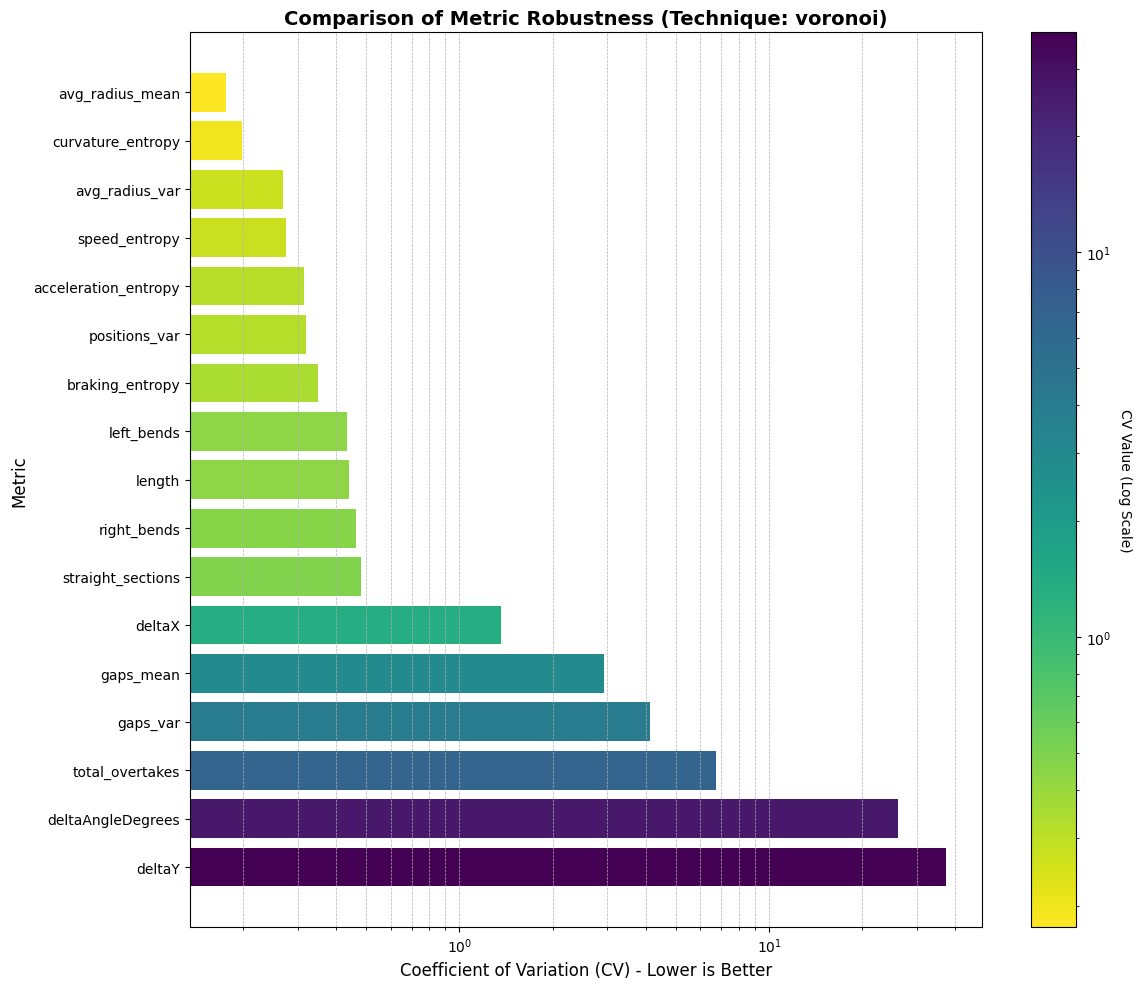

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Final Summary Plot: Comparing Metric Robustness

# Use the 'cv_df' DataFrame calculated earlier, which contains the Coefficient of Variation for each metric.
# Ensure any rows with NaN CV values are dropped, as they cannot be plotted.
plot_data = cv_df.dropna(subset=['CV']).copy()

# For this plot, it is more informative to sort with the most robust (lowest CV) at the top.
plot_data.sort_values('CV', ascending=True, inplace=True)

print("\n--- Generating Summary Plot for Metric Robustness ---")
print("This plot compares the Coefficient of Variation (CV) for all metrics.")
print("Metrics at the top are the most robust (least noisy). A logarithmic scale is used for clarity.")

if not plot_data.empty:
    plt.figure(figsize=(12, 10))

    # Create a color map. We use a reversed sequential map so low CVs (good) get one color
    # and high CVs (bad) get another. 'viridis_r' goes from yellow (high) to purple (low).
    # We normalize the colors based on a log scale for better visual correspondence.
    norm = mcolors.LogNorm(vmin=plot_data['CV'].min(), vmax=plot_data['CV'].max())
    cmap = plt.get_cmap('viridis_r')
    colors = cmap(norm(plot_data['CV']))

    # Create the horizontal bar plot.
    bars = plt.barh(plot_data['Metric'], plot_data['CV'], color=colors)
    
    # Set the x-axis to a logarithmic scale. This is crucial for comparing metrics
    # with vastly different scales of noisiness.
    plt.xscale('log')
    
    # --- Aesthetics and Labels ---
    plt.xlabel('Coefficient of Variation (CV) - Lower is Better', fontsize=12)
    plt.ylabel('Metric', fontsize=12)
    plt.title('Comparison of Metric Robustness (Technique: ' + TECHNIQUE_NAME + ')', fontsize=14, weight='bold')
    
    # Invert the y-axis so the metric with the lowest CV is at the top.
    plt.gca().invert_yaxis()
    
    # Add a grid for easier reading of the log scale.
    plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    # Add a color bar to show the mapping of color to CV value.
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('CV Value (Log Scale)', rotation=270, labelpad=15)

    plt.show()

else:
    print("Could not generate summary plot: 'cv_df' is empty or contains no valid data.", file=sys.stderr)

In [5]:
# Normalize selected geometry features by track length and replace original columns.
columns_to_normalize = ['straight_sections', 'left_bends', 'right_bends']
divisor_column = 'length'

updatable_cols = [col for col in columns_to_normalize if col in df_averaged_metrics_per_seed.columns]
updated_cols = []

if divisor_column in df_averaged_metrics_per_seed.columns:
    if updatable_cols:
        for col in updatable_cols:
            df_averaged_metrics_per_seed[col] /= df_averaged_metrics_per_seed[divisor_column]
            updated_cols.append(col)
        
        print("Updated and normalized the following columns in place:")
        print(df_averaged_metrics_per_seed[updated_cols].head())
    else:
        print("Warning: None of the specified columns for normalization were found in the DataFrame.", file=sys.stderr)
else:
    print(f"Skipping normalization: Divisor column '{divisor_column}' not found.", file=sys.stderr)

Updated and normalized the following columns in place:
   straight_sections  left_bends  right_bends
0           0.019090    0.026922     0.019579
1           0.021735    0.027250     0.022709
2           0.024328    0.036636     0.032437
3           0.027626    0.029083     0.029639
4           0.039063    0.041291     0.039587


Compute and visualize the correlation matrix for all numeric features (including candidate fitness measures).


--- Correlation Analysis of Averaged Metrics for 'voronoi' ---

Correlation Matrix (Averaged Metrics per Seed):
                      length  deltaX  deltaY  deltaAngleDegrees  \
length                  1.00    0.17   -0.08               0.09   
deltaX                  0.17    1.00    0.01               0.01   
deltaY                 -0.08    0.01    1.00               0.22   
deltaAngleDegrees       0.09    0.01    0.22               1.00   
speed_entropy          -0.42   -0.29   -0.34              -0.03   
acceleration_entropy   -0.39   -0.24   -0.35              -0.04   
braking_entropy        -0.13   -0.19   -0.29               0.12   
avg_radius_mean         0.08    0.23    0.07              -0.06   
gaps_mean              -0.08   -0.11   -0.08               0.26   
right_bends             0.12   -0.01    0.20               0.32   
avg_radius_var          0.09    0.29    0.16              -0.05   
total_overtakes         0.24    0.62   -0.09              -0.01   
straight_section

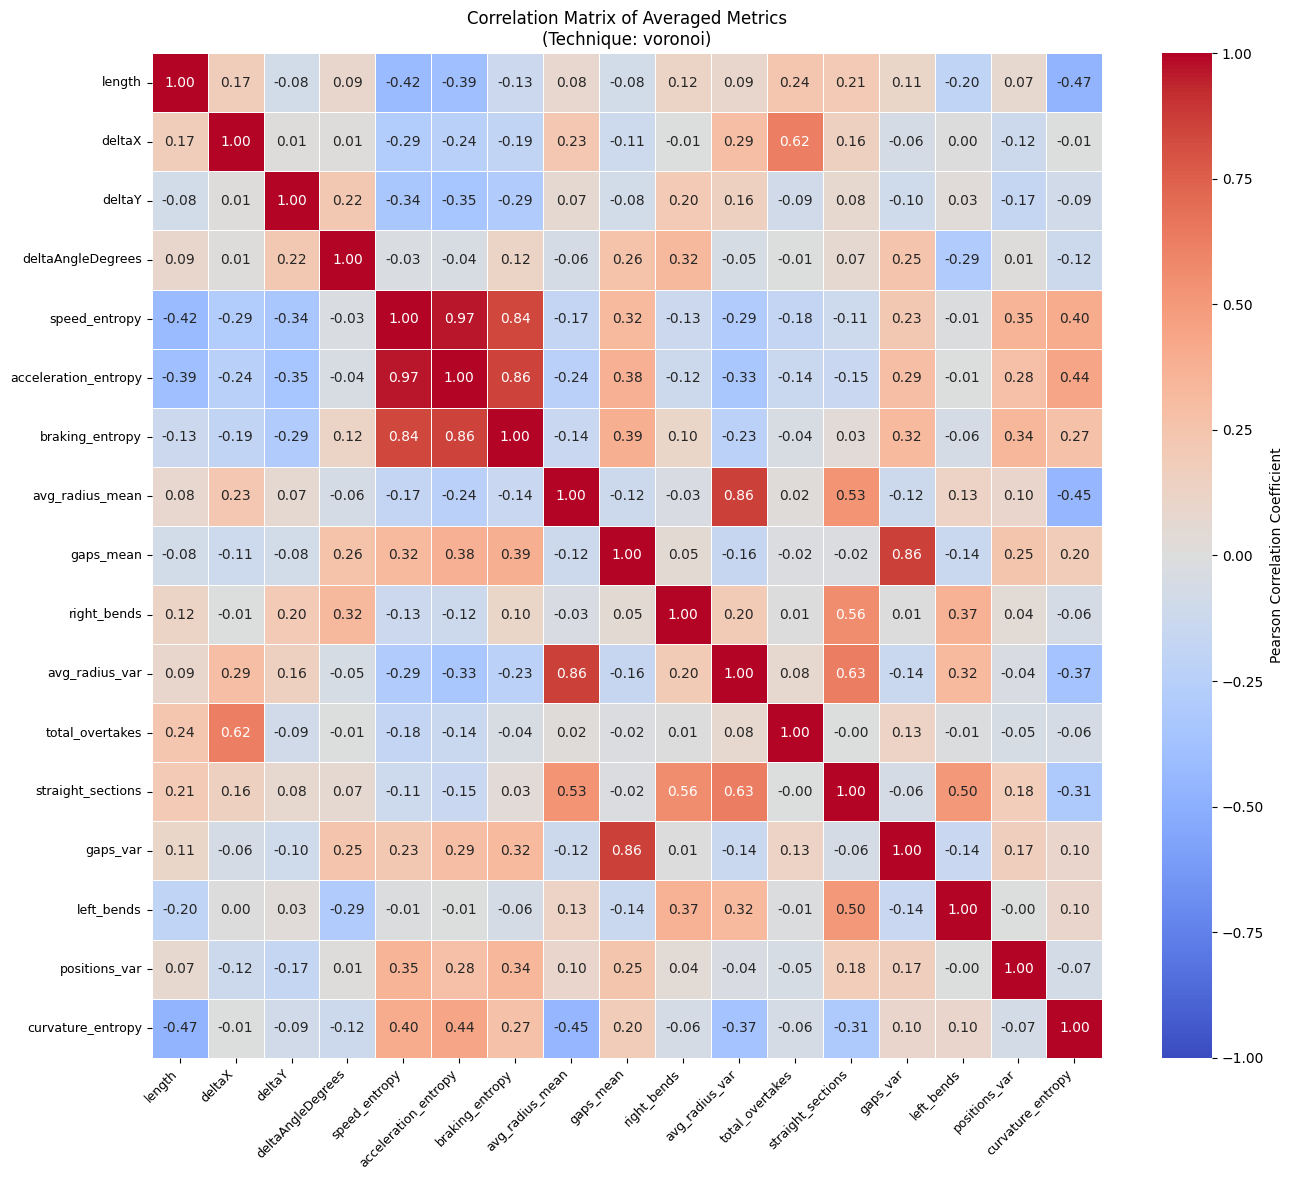


Significant Correlations (|r| >= 0.7):
- speed_entropy & acceleration_entropy: 0.97
- speed_entropy & braking_entropy: 0.84
- acceleration_entropy & braking_entropy: 0.86
- avg_radius_mean & avg_radius_var: 0.86
- gaps_mean & gaps_var: 0.86


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns 

print(f"\n--- Correlation Analysis of Averaged Metrics for '{TECHNIQUE_NAME}' ---")

CORRELATION_THRESHOLD = 0.7 # Define the threshold for highlighting significant correlations
correlation_matrix = None

# Pre-checks for necessary data
if 'df_averaged_metrics_per_seed' not in locals() or df_averaged_metrics_per_seed.empty:
    print("Skipping correlation analysis: Averaged data ('df_averaged_metrics_per_seed') is missing or empty.", file=sys.stderr)
elif 'metrics_to_analyze' not in locals() or not metrics_to_analyze:
    print("Skipping correlation analysis: 'metrics_to_analyze' list is missing or empty.", file=sys.stderr)
else:
    # Verify that the specified metrics exist in the averaged DataFrame
    available_metrics = [m for m in metrics_to_analyze if m in df_averaged_metrics_per_seed.columns]

    if len(available_metrics) < len(metrics_to_analyze):
        missing = set(metrics_to_analyze) - set(available_metrics)
        print(f"Warning: The following metrics are not in the averaged DataFrame and will be excluded: {missing}", file=sys.stderr)

    if len(available_metrics) < 2:
        print(f"Skipping correlation analysis: Need at least 2 available metrics to calculate correlation. Found: {len(available_metrics)}.", file=sys.stderr)
    else:
        # Select only the available metric columns for correlation calculation
        df_metrics_for_corr = df_averaged_metrics_per_seed[available_metrics]

        # Calculate the Pearson correlation matrix
        # .corr() automatically handles pairwise deletion for NaNs by default
        try:
            correlation_matrix = df_metrics_for_corr.corr(method='pearson')

            print("\nCorrelation Matrix (Averaged Metrics per Seed):")
            print(correlation_matrix.round(2))

            # Plotting the heatmap using seaborn for potentially better aesthetics
            plt.figure(figsize=(max(6, len(available_metrics)*0.8), max(5, len(available_metrics)*0.7)))
            sns.heatmap(correlation_matrix,
                        annot=True,      # Show correlation values on the heatmap
                        cmap='coolwarm', # Diverging colormap centered around 0
                        fmt=".2f",       # Format annotations to 2 decimal places
                        linewidths=.5,   # Add lines between cells
                        vmin=-1, vmax=1, # Ensure color scale covers full range [-1, 1]
                        cbar_kws={'label': 'Pearson Correlation Coefficient'}) # Add label to color bar
            plt.title(f"Correlation Matrix of Averaged Metrics\n(Technique: {TECHNIQUE_NAME})", fontsize=12)
            plt.xticks(rotation=45, ha='right', fontsize=9)
            plt.yticks(rotation=0, fontsize=9)
            plt.tight_layout()
            plt.show()

            # Find and print significant correlations
            print(f"\nSignificant Correlations (|r| >= {CORRELATION_THRESHOLD:.1f}):")
            significant_pairs_found = False
            # Iterate through the upper triangle of the matrix (excluding the diagonal)
            for i in range(len(correlation_matrix.columns)):
                for j in range(i + 1, len(correlation_matrix.columns)):
                    metric1 = correlation_matrix.columns[i]
                    metric2 = correlation_matrix.columns[j]
                    correlation_value = correlation_matrix.loc[metric1, metric2]

                    # Check if the absolute value meets the threshold and is not NaN
                    if pd.notna(correlation_value) and abs(correlation_value) >= CORRELATION_THRESHOLD:
                        print(f"- {metric1} & {metric2}: {correlation_value:.2f}")
                        significant_pairs_found = True

            if not significant_pairs_found:
                print(f"  No pairs found with absolute correlation >= {CORRELATION_THRESHOLD:.1f}")

        except Exception as e:
            print(f"An error occurred during correlation calculation or plotting: {e}", file=sys.stderr)
            correlation_matrix = None # Ensure it's None if calculation failed

# --- correlation_matrix variable holds the result (or None if failed) ---
if correlation_matrix is None and ('df_averaged_metrics_per_seed' in locals() and not df_averaged_metrics_per_seed.empty):
     print("\nCorrelation matrix could not be generated.")

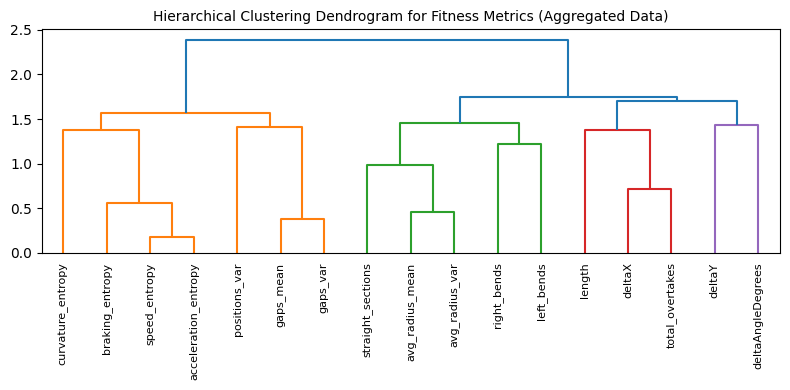

In [7]:
import scipy.cluster.hierarchy as sch
features = [feat for feat in metrics_to_analyze if feat in df_averaged_metrics_per_seed.columns]
    
# Compute the correlation matrix for the selected features.
corr_fitness_avg = df_averaged_metrics_per_seed[features].corr()

# Perform hierarchical clustering directly on the correlation matrix using average linkage.
linked_avg = sch.linkage(corr_fitness_avg, method='average')

# Plot the dendrogram.
plt.figure(figsize=(8, 4))
dendro_avg = sch.dendrogram(linked_avg, labels=corr_fitness_avg.columns, leaf_rotation=90, leaf_font_size=8)
plt.title("Hierarchical Clustering Dendrogram for Fitness Metrics (Aggregated Data)", fontsize=10)
plt.tight_layout()
plt.show()
